# Example Fe55 notebook

Initially written for the bootcamp at SLAC Nov 2018 by Simon Krughoff

### Setup

Before running this notebook, you'll need to set up the `obs_lsstCam` module. Before doing the setup procedure below, you might want to run the notebook until it crashes so you see what the error message looks like.

Step-by-step instructions:

1. Start a terminal in JupyterLab. In the terminal, setup the stack: `source /opt/lsst/software/stack/loadLSST.bash`

2. Create and/or switch into a folder where you want to put your local versions of the LSST Stack (e.g., `~/repos`)

Run the following commands

```
git clone https://github.com/lsst/obs_lsstCam.git
cd obs_lsstCam
git checkout tickets/DM-16390
setup -j -r .
scons
```

3. Add `setup -k -r path_to_repos/obs_lsstCam` to `$HOME/notebooks/.user_setups`.

4. Restart your kernel.

Just for fun, check what version of the Stack you are using. This notebook has been tested on `w_2018_44`.

In [1]:
! eups list -s | grep lsst_distrib

lsst_distrib          16.0-1-g3bbe181+25 	current w_2018_44 setup


### Imports

In [2]:
%matplotlib inline

# system imports
from matplotlib import pylab as plt
from scipy.optimize import leastsq
import numpy
import os

# LSST stack imports
from lsst.daf.persistence import Butler
import lsst.afw.display as afwDisplay
from lsst.ip.isr import IsrTask
import lsst.afw.detection as afwDetection


# Firefly client imports
from firefly_client import FireflyClient
from IPython.display import IFrame

### Set up the config for the ISR task.  This essentially turns off all processing other than overscan and bias correction.

In [3]:
isr_config = IsrTask.ConfigClass()

isr_config.doDark=False
isr_config.doFlat=False
isr_config.doFringe=False
isr_config.doDefect=False
isr_config.doAddDistortionModel=False
isr_config.doLinearize=False

### Construct the `IsrTask` with the above configuration

In [4]:
isr = IsrTask(config=isr_config)

### Retrieve the data necessary to perform ISR.  This is just the raw data and the bias frame.  Note there are multiple integrations.  This notebook only looks at one of them.

In [5]:
BOOTCAMP_REPO_DIR= '/project/bootcamp/repo_RTM-011/'
butler = Butler(BOOTCAMP_REPO_DIR)
print(butler.queryMetadata('raw', ['visit'], dataId={'imageType': 'FE55'}))

dId = {'visit': 266761457, 'detector': 1}
raw = butler.get('raw', **dId)
bias = butler.get('bias', **dId)

[266761457, 266761772, 266762086, 266762400, 266762716]


In [6]:
result = isr.run(raw, bias=bias)

### Set up the necessary classes for using firefly to look at the data.

In [7]:
my_channel = '{}_test_channel'.format(os.environ['USER'])
server = 'https://lsst-lspdev.ncsa.illinois.edu'


ff='{}/firefly/slate.html?__wsch={}'.format(server, my_channel)
IFrame(ff,800,600)

In [8]:
afwDisplay.setDefaultBackend('firefly')
afw_display = afwDisplay.getDisplay(frame=1, 
                                    name=my_channel)

### Disaplay the frame after ISR

In [9]:
afw_display.mtv(result.exposure)

### Set up the functions doing the fit

In [10]:
def double_gaussian(x, params):
    (c1, mu1, sigma1, c2, mu2, sigma2) = params
    res =  c1 * numpy.exp(-(x - mu1)**2.0/(2.0 * sigma1**2.0)) \
          + c2 * numpy.exp(-(x - mu2)**2.0/(2.0 * sigma2**2.0))
    return res

def double_gaussian_fit(params, x, y):
    fit = double_gaussian( x, params )
    return (fit - y)

### Loop over amps and fit a double gaussian to the distribution of counts in detections

In [11]:
xs = []
ys = []
fits = []
detector = result.exposure.getDetector()
for amp in detector:
    masked_img = result.exposure.getMaskedImage()
    work_img = masked_img[amp.getBBox()]
    arr = work_img.getImage().getArray()
    
    bkgd = numpy.median(arr) # estimate a background and subtract it
    arr -= bkgd

    thresh = afwDetection.Threshold(200)
    fs = afwDetection.FootprintSet(work_img, thresh) # detect hits
    fs = afwDetection.FootprintSet(fs, 2, False) # grow the detection footprints
    fs.makeHeavy(work_img)

    foots = fs.getFootprints()

    counts = []
    for foot in foots:
        if foot.getImageArray().size < 25:  # throw out big footprints/CRs since we know the hits should be in a single pixel modulo the charge diffusion.
            counts.append(numpy.sum(foot.getImageArray()))

    hist = numpy.histogram(counts, bins=1500+numpy.array(range(60))*10.) # generate distribution to fit

    y = hist[0]
    x = [(hist[1][i]+hist[1][i+1])/2 for i in range(len(hist[1])-1)]

    fit = leastsq(double_gaussian_fit, [50.,1700,30.,5.,1850.,60.], args=(x, y)) # starting parameters were determined by examining a representative distribution
    xs.append(x)
    ys.append(y)
    fits.append(fit)

### plot distributions for all 16 amps.

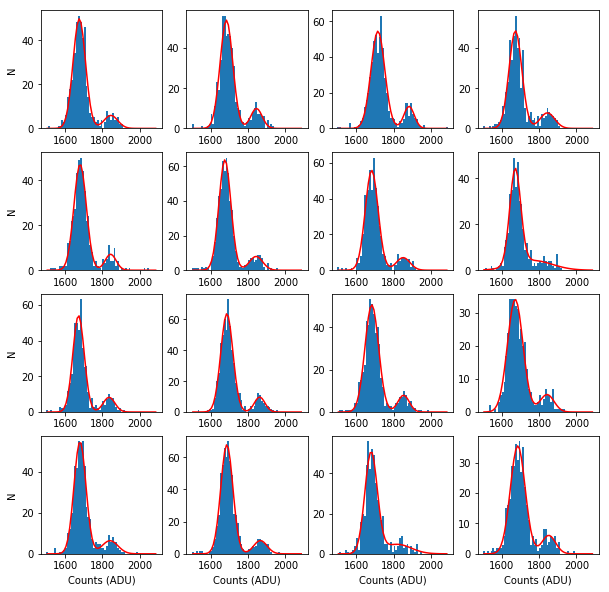

In [12]:
fig, axs = plt.subplots(4, 4, figsize=(10, 10))
for i in range(16):
    x = xs[i]
    y = ys[i]
    fit = fits[i]
    indx = i%4
    indy = i//4
    axs[indx][indy].bar(x, y, width=10)
    axs[indx][indy].plot(x, double_gaussian(x, fit[0]), c='r')
    if indx == 3:
        axs[indx][indy].set_xlabel('Counts (ADU)')
    if indy == 0:
        axs[indx][indy].set_ylabel('N')

In [13]:
afw_display.mtv(work_img) # have a look at an example amp

In [14]:
FE55_electrons = 1594

### Calculate gain and print them

In [15]:
for i in range(16):
    print("Gain for amp %s -- %.5f"%(detector[i].getName(), FE55_electrons/fits[i][0][1]))

Gain for amp C10 -- 0.95093
Gain for amp C11 -- 0.94840
Gain for amp C12 -- 0.95316
Gain for amp C13 -- 0.94884
Gain for amp C14 -- 0.94613
Gain for amp C15 -- 0.95074
Gain for amp C16 -- 0.94486
Gain for amp C17 -- 0.94494
Gain for amp C07 -- 0.92878
Gain for amp C06 -- 0.94703
Gain for amp C05 -- 0.94673
Gain for amp C04 -- 0.94892
Gain for amp C03 -- 0.95265
Gain for amp C02 -- 0.95315
Gain for amp C01 -- 0.95326
Gain for amp C00 -- 0.94551
